# Quinta abordagem de predição: 3 classes

CLASSE 0 = notas 0, 1, 2 e 3 (negativo)

CLASSE 1 = notas 4, 5, 6, 7 e 8 (confuso)

CLASSE 2 = notas 9 e 10 (positivo)

- com equilíbrio de amostras
- com validação cruzada 
- com otimização de parâmetros

## Bibliotecas e Configurações

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

## Importação dos Dados

In [41]:
df = pd.read_csv('NPS_Complete_UFF_2022-07-18_2022-12-31_extra-tratado.csv', sep=';')

display(df)

,ANF,USERVALUEQ1_LABEL,USERVALUEQ2_VALUE,vol_Rede_Social,vol_Video,vol_Comunicacao,vol_Loja_de_Apps,vol_Musica,vol_Google,vol_Navegacao,...,term_fabr_motorola,term_fabr_não informado,term_fabr_outros,term_fabr_samsung,term_fabr_xiaomi,device_tech_2G,device_tech_3G,device_tech_4G,device_tech_5G,Qtd_CRM
0,51,8,Não Informado,8.111028,6.282269,5.894406,5.347112,-6.907755,3.295874,3.295874,...,0,0,0,0,0,0,0,1,0,0
1,11,9,Plano/Bonus,7.180832,5.153297,5.283209,1.946053,-6.907755,-6.907755,-6.907755,...,0,0,0,1,0,0,0,1,0,0
2,37,10,Velocidade,8.094379,5.846442,6.682110,2.890427,4.844195,1.609638,-6.907755,...,1,0,0,0,0,0,0,1,0,0
3,81,10,Outros,4.897847,5.771444,1.386544,-6.907755,-6.907755,0.001000,-6.907755,...,0,0,1,0,0,0,1,0,0,0
4,85,10,Sinal/Cobertura,3.784212,3.434019,5.918897,1.791926,-6.907755,1.386544,-6.907755,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45201,48,0,Sinal/Cobertura,5.262695,5.398167,3.828663,5.075180,-6.907755,0.001000,-6.907755,...,0,0,0,0,1,0,0,1,0,0
45202,35,7,Sinal/Cobertura,7.978654,6.054442,7.756196,3.912043,-6.907755,3.401231,-6.907755,...,0,0,0,1,0,0,0,1,0,0
45203,43,10,Duracao pacote dados,3.434019,5.332724,4.248510,1.386544,-6.907755,-6.907755,-6.907755,...,1,0,0,0,0,0,0,0,1,0
45204,42,10,Sinal/Cobertura,-6.907755,5.159061,1.386544,-6.907755,-6.907755,-6.907755,-6.907755,...,0,0,0,1,0,0,1,0,0,0


### Notas atribuídas (distribuição)

In [42]:
df['USERVALUEQ1_LABEL'].value_counts() # divisão de clientes por nota atribuída

10    18937
8      5477
9      4578
0      4099
7      2879
5      2756
6      1684
1      1438
3      1202
2      1147
4      1009
Name: USERVALUEQ1_LABEL, dtype: int64

## Machine Learning

### Bibliotecas

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier

### Train Test Split -> 3 classes

In [44]:
# CLASSE 0: Notas de 0 a 3
# CLASSE 1: Notas de 4 a 8
# CLASSE 2: Notas 9 e 10

df['CLASSE'] = df['USERVALUEQ1_LABEL'].apply(lambda x: 0 if x <= 3 else 1 if x <= 8 else 2)

df['CLASSE'].value_counts() # distribuição

2    23515
1    13805
0     7886
Name: CLASSE, dtype: int64

In [45]:
# Igualar a quantidade de amostras de cada classe fazendo 7800 de cada
df = df.groupby('CLASSE').apply(lambda x: x.sample(7800)).reset_index(drop=True)

In [46]:
# Amostrar 70% para treino e 30% para teste
df_train = df.sample(frac=0.7, random_state=1)
df_test = df.drop(df_train.index)

In [47]:
# Separar os dados de treino em X e y exluindo dados que vazam informação
X_train = df_train.drop(columns=['USERVALUEQ1_LABEL', 'USERVALUEQ2_VALUE', 'NPS_Class_Detrator', 'NPS_Class_Passivo', 'NPS_Class_Promotor', 'CLASSE'])
y_train = df_train['CLASSE']

# Separar os dados de teste em X e y
X_test = df_test.drop(columns=['USERVALUEQ1_LABEL', 'USERVALUEQ2_VALUE', 'NPS_Class_Detrator', 'NPS_Class_Passivo', 'NPS_Class_Promotor', 'CLASSE'])
y_test = df_test['CLASSE']

### XGBoost

In [48]:
xgb = XGBClassifier(objective='binary:hinge')
xgb.get_params()

{'objective': 'binary:hinge',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [49]:
hyper_dict = {
    "colsample_bytree": uniform(0.7, 0.3), # percentual de colunas a serem amostradas para cada árvore (colunas)
    "learning_rate": uniform(0.03, 0.3), # taxa de aprendizado 
    "max_depth": randint(4, 8), # profundidade máxima de cada árvore
    "n_estimators": randint(100, 250), # número de árvores
    "subsample": uniform(0.5, 0.9) # percentual de amostras a serem usadas para cada árvore (linhas)
}

search_cv = RandomizedSearchCV(xgb, param_distributions=hyper_dict, n_iter=10, scoring='f1', random_state=0)
search_cv.fit(X_train, y_train)

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users

In [ ]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'colsample_bytree': 0.8646440511781974, 'learning_rate': 0.24455680991172585, 'max_depth': 7, 'n_estimators': 203, 'subsample': 0.8812893194050142}


In [ ]:
best_model_xgb = search_cv.best_estimator_
best_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8646440511781974, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24455680991172585,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=203, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred = best_model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41      2368
           1       0.34      0.37      0.35      2282
           2       0.41      0.40      0.40      2370

    accuracy                           0.39      7020
   macro avg       0.39      0.39      0.39      7020
weighted avg       0.39      0.39      0.39      7020



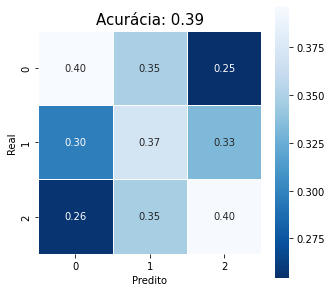

In [ ]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Real');
plt.xlabel('Predito');
all_sample_title = 'Acurácia: {:.2f}'.format(best_model_xgb.score(X_test, y_test))
plt.title(all_sample_title, size = 15);
plt.rcParams.update({'font.size': 20})

In [ ]:
# feature importance
feature_importances = pd.DataFrame(best_model_xgb.feature_importances_,
                                    index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                           importance
Qtd_CRM                      0.038272
CUSTOMER_SEGMENT_Pré-pago    0.029270
CUSTOMER_SEGMENT_Controle    0.027060
dias_franquia_zerada         0.022526
term_fabr_outros             0.020693
term_fabr_apple              0.020405
dias_traf_red                0.019922
term_fabr_não informado      0.019690
FLAG_PARAMETRO_R             0.019168
term_fabr_lg                 0.018622
SURVEY_Base                  0.018619
CUSTOMER_SEGMENT_Pós-pago    0.018278
imsi_LTE                     0.018268
ACD_STATUS_p                 0.017529
SURVEY_Uso Dados             0.017471
VoLTE_perc                   0.017381
vol_MarketPlace              0.017279
qtde_celula                  0.017245
tot_volume                   0.017202
vol_Musica                   0.017131
DISP_STATUS_p                0.017124
vol_Ecommerce                0.017036
vol_Video                    0.017031
tot_duracao_chamada          0.016953
vol_Alimentacao              0.016817
originada_pe

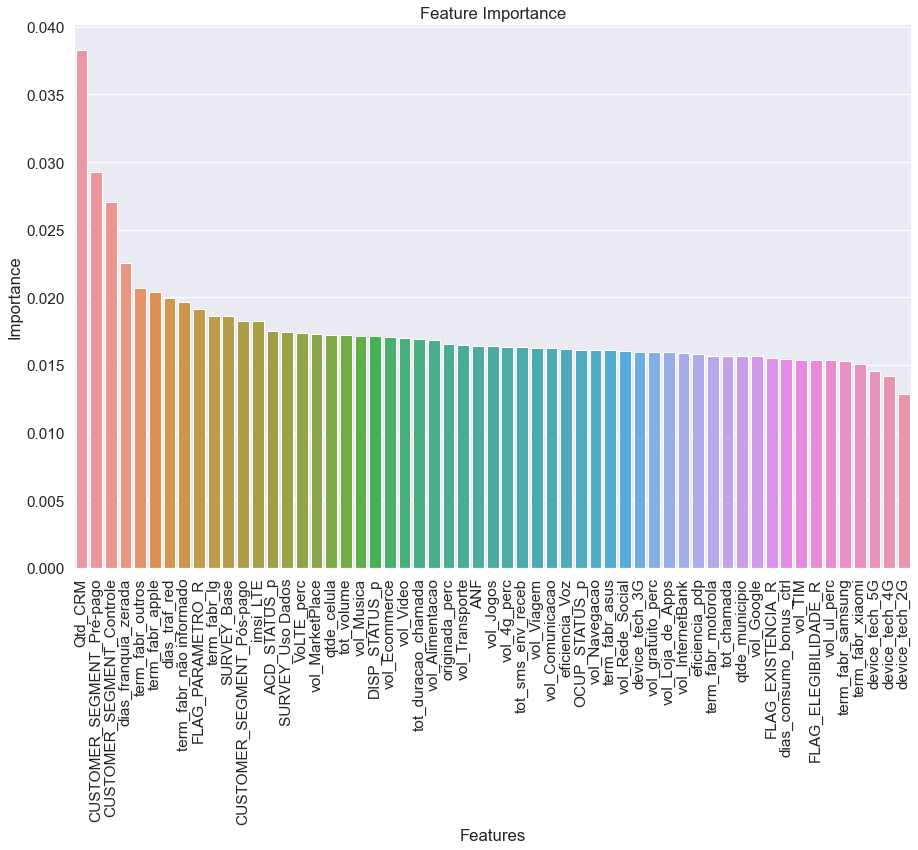

In [ ]:
# histograma das features mais importantes
plt.figure(figsize=(15,10))
sns.set_style('white')
sns.set(font_scale=1.4)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
hyper_dict = {
    "max_depth": randint(4, 8), # profundidade máxima de cada árvore
    "n_estimators": randint(100, 250), # número de árvores
    "min_samples_leaf": randint(1, 4), # número mínimo de amostras em cada folha
    "max_features": randint(2, 10) # número máximo de features a serem consideradas em cada árvore
}

search_cv = RandomizedSearchCV(rf, param_distributions=hyper_dict, n_iter=10, scoring='f1', random_state=0)
search_cv.fit(X_train, y_train)

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000240AAA359C0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000240AAA363B0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000240AAA349A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000240AAA352D0>},
                   random_state=0, scoring='f1')

In [ ]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'max_depth': 4, 'max_features': 9, 'min_samples_leaf': 2, 'n_estimators': 167}


In [ ]:
best_model_rf = search_cv.best_estimator_
best_model_rf

RandomForestClassifier(max_depth=4, max_features=9, min_samples_leaf=2,
                       n_estimators=167)

In [ ]:
y_pred = best_model_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.36      0.41      2368
           1       0.37      0.42      0.39      2282
           2       0.42      0.47      0.45      2370

    accuracy                           0.41      7020
   macro avg       0.42      0.41      0.41      7020
weighted avg       0.42      0.41      0.41      7020



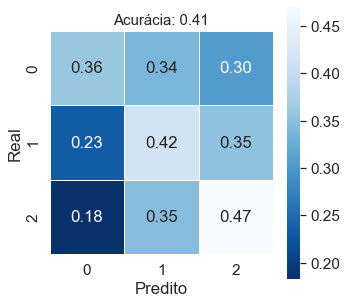

In [ ]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Real');
plt.xlabel('Predito');
all_sample_title = 'Acurácia: {:.2f}'.format(best_model_rf.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [ ]:
# feature importance
feature_importances = pd.DataFrame(best_model_rf.feature_importances_,
                                    index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                           importance
qtde_celula                  0.087445
dias_franquia_zerada         0.087081
CUSTOMER_SEGMENT_Pré-pago    0.084390
Qtd_CRM                      0.082481
VoLTE_perc                   0.047263
vol_MarketPlace              0.044599
ANF                          0.044550
vol_Navegacao                0.044410
vol_4g_perc                  0.037390
CUSTOMER_SEGMENT_Controle    0.033422
vol_Musica                   0.032923
qtde_municipio               0.031466
tot_volume                   0.031211
tot_sms_env_receb            0.023504
originada_perc               0.021710
eficiencia_pdp               0.021468
vol_TIM                      0.020550
FLAG_EXISTENCIA_R            0.017166
vol_Rede_Social              0.017114
tot_chamada                  0.016766
vol_Video                    0.015984
vol_gratuito_perc            0.013507
tot_duracao_chamada          0.012726
vol_Loja_de_Apps             0.012286
vol_Comunicacao              0.011563
vol_Alimenta

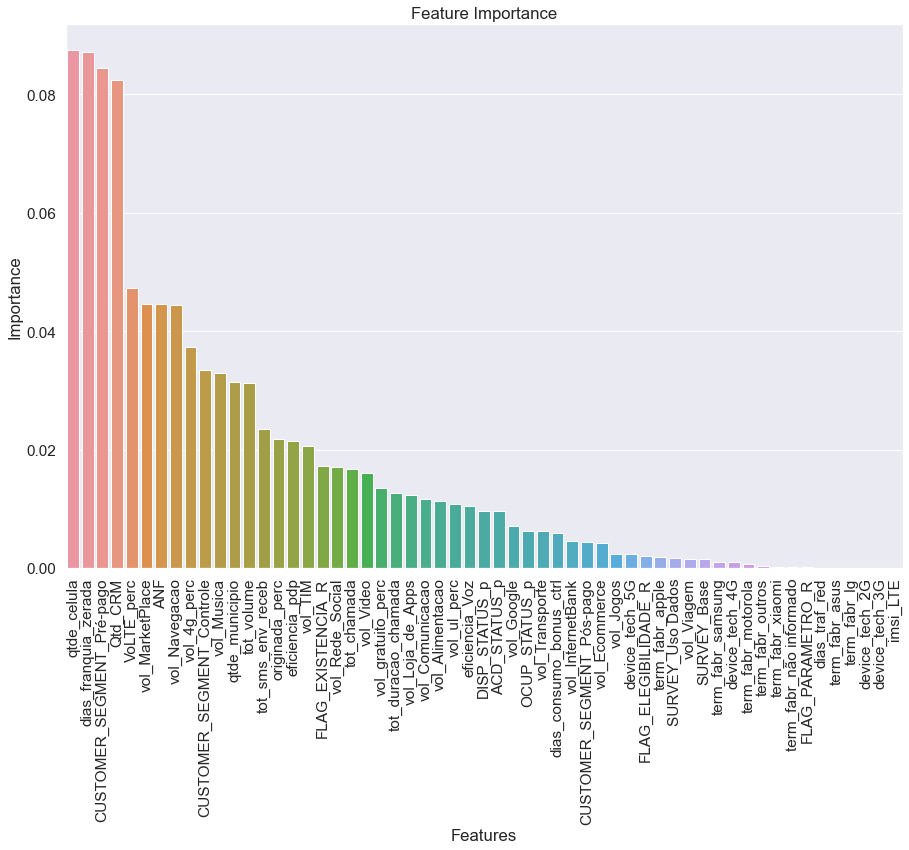

In [ ]:
# histograma das features mais importantes
plt.figure(figsize=(15,10))
sns.set_style('white')
sns.set(font_scale=1.4)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()